In [1]:
import numpy as np
import time
from numpy import *
from scipy import io

import matplotlib.pyplot as plt

import torch
from torch.optim.lr_scheduler import ReduceLROnPlateau

import sys
sys.path.append("../")

from spline import splineBasis
from ado import * 

# make noisy and sparse data

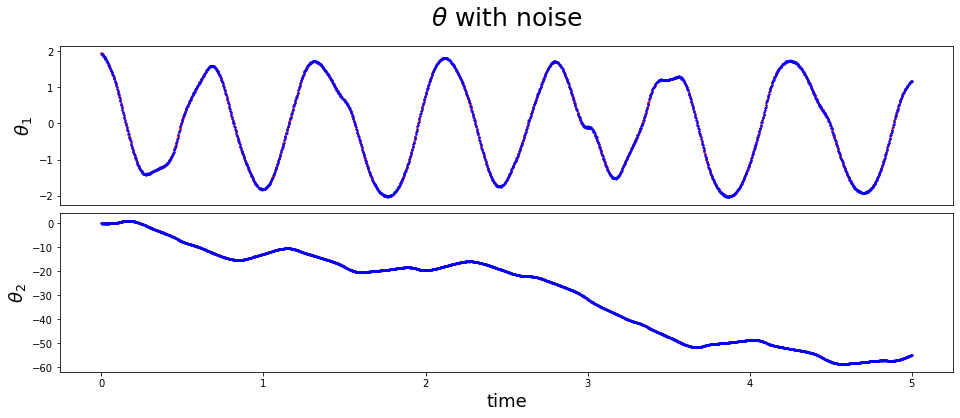

In [3]:
sim_measurement = io.loadmat('../systems/Double pendulum/data_ode113.mat')['x'][:2001, :]

t_m_all = np.linspace(0, 5, 2001)

x_sample = sim_measurement[:, :2]
w_sample = sim_measurement[:, 2:4]

x_sample_shift = x_sample.copy()
    
for i in range(x_sample_shift.shape[0]):
    if abs(x_sample_shift[i, 0]) >= np.pi:
        x_sample_shift[i:, 0] -= 2 * np.pi * np.sign(x_sample_shift[i, 0])
    if abs(x_sample_shift[i, 1]) >= np.pi:
        x_sample_shift[i:, 1] -= 2 * np.pi * np.sign(x_sample_shift[i, 1])


n_ratio = 0.02 # noise ratio
sub_ratio = 1 # downsample ratio 
np.random.seed(0)
sub_idx = sorted(np.random.choice(len(t_m_all), int(len(t_m_all) * sub_ratio), replace=False))
t_m = t_m_all[sub_idx]

coordx1_true = 9.1 * np.sin(x_sample[:, 0])
coordy1_true = -9.1 * np.cos(x_sample[:, 0])
coordx2_true = coordx1_true + 7 * np.sin(x_sample[:, 1])
coordy2_true = coordy1_true - 7 * np.cos(x_sample[:, 1])

np.random.seed(0)

coordx1_n = np.random.normal(0,1,len(t_m_all))
coordx1_n = coordx1_n / np.std(coordx1_n)
coordx1_noise = (coordx1_true + n_ratio * np.std(coordx1_true) * coordx1_n)[sub_idx]

coordy1_n = np.random.normal(0,1,len(t_m_all))
coordy1_n = coordy1_n / np.std(coordy1_n)
coordy1_noise = (coordy1_true + n_ratio * np.std(coordy1_true) * coordy1_n)[sub_idx]

coordx2_n = np.random.normal(0,1,len(t_m_all))
coordx2_n = coordx2_n / np.std(coordx2_n)
coordx2_noise = (coordx2_true + n_ratio * np.std(coordx2_true) * coordx2_n)[sub_idx]

coordy2_n = np.random.normal(0,1,len(t_m_all))
coordy2_n = coordy2_n / np.std(coordy2_n)
coordy2_noise = (coordy2_true + n_ratio * np.std(coordy2_true) * coordy2_n)[sub_idx]


x_noise_shift = np.zeros([len(t_m), 2])

for i in range(len(t_m)):
    x_noise_shift[i, 0] = math.atan2(coordy1_noise[i], coordx1_noise[i]) + 0.5*np.pi
    x_noise_shift[i, 1] = math.atan2(coordy2_noise[i] - coordy1_noise[i], 
                               coordx2_noise[i] - coordx1_noise[i]) + 0.5*np.pi
for i in range(x_noise_shift.shape[0]):
    for j in range(x_noise_shift.shape[1]):
        if x_noise_shift[i, j] > np.pi:
            x_noise_shift[i, j] = x_noise_shift[i, j] - 2*np.pi
            
x_noise = x_noise_shift.copy()
    
for i in range(1, x_noise_shift.shape[0]):
    if abs(x_noise_shift[i, 0] - x_noise_shift[i-1, 0]) >= np.pi:
        x_noise[i:, 0] = x_noise[i:, 0] + 2 * np.pi * np.sign(x_noise_shift[i-1, 0] - x_noise_shift[i, 0])
    if abs(x_noise_shift[i, 1] - x_noise_shift[i-1, 1]) >= np.pi:
        x_noise[i:, 1] = x_noise[i:, 1] + 2 * np.pi * np.sign(x_noise_shift[i-1, 1] - x_noise_shift[i, 1])

        
fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(211)
ax.set_title('$\\theta$ with noise', fontsize=25, pad=20)
ax.scatter(t_m_all, x_sample[:, 0], c='r', s=1.5)
ax.scatter(t_m, x_noise[:, 0], c='b', s=1.5)
ax.axes.xaxis.set_visible(False)
ax.set_ylabel('$\\theta_1$', fontsize=18)

ax = fig.add_subplot(212)
ax.scatter(t_m_all, x_sample[:, 1], c='r', s=1.5)
ax.scatter(t_m, x_noise[:, 1], c='b', s=1.5)
ax.set_ylabel('$\\theta_2$', fontsize=18)
ax.set_xlabel('time', fontsize=18)

plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

# Baseline: pySINDy

In [4]:
from pysindy import SINDy
from pysindy.feature_library import CustomLibrary
from pysindy.differentiation import SmoothedFiniteDifference

sfd = SmoothedFiniteDifference(smoother_kws={'window_length': 5})
w_sfd = sfd._differentiate(x_noise, t_m)
dw_sfd = sfd._differentiate(w_sfd, t_m)

self_library = ['dw1*np.cos(x1-x2)', 'dw2*np.cos(x1-x2)', 'w1**2*np.sin(x1-x2)', 'w2**2*np.sin(x1-x2)', 
                'w1**2*np.sin(x1)', 'w2**2*np.sin(x1)', 'w1**2*np.sin(x2)', 'w2**2*np.sin(x2)',
                'w1*np.sin(x1-x2)', 'w2*np.sin(x1-x2)', 'w1*np.sin(x1)', 'w2*np.sin(x1)', 'w1*np.sin(x2)', 'w2*np.sin(x2)',
                'np.sin(x1)', 'np.sin(x2)', 'np.sin(x1-x2)']
num_term = len(self_library)
t_m_len = len(t_m)


from pysindy import SINDy
from pysindy.feature_library import CustomLibrary

x1 = x_noise[:, 0]
x2 = x_noise[:, 1]
w1 = w_sfd[:, 0]
w2 = w_sfd[:, 1]
dw1 = dw_sfd[:, 0]
dw2 = dw_sfd[:, 1]

x_sindy = np.vstack([x1, x2, w1, w2, dw1, dw2]).T

functions = [lambda x1,x2,w1,w2,dw1,dw2: dw1*np.cos(x1-x2),
             lambda x1,x2,w1,w2,dw1,dw2: dw2*np.cos(x1-x2), 
             lambda x1,x2,w1,w2,dw1,dw2: w1**2*np.sin(x1-x2), 
             lambda x1,x2,w1,w2,dw1,dw2: w2**2*np.sin(x1-x2), 
             lambda x1,x2,w1,w2,dw1,dw2: w1**2*np.sin(x1), 
             lambda x1,x2,w1,w2,dw1,dw2: w2**2*np.sin(x1), 
             lambda x1,x2,w1,w2,dw1,dw2: w1**2*np.sin(x2), 
             lambda x1,x2,w1,w2,dw1,dw2: w2**2*np.sin(x2), 
             lambda x1,x2,w1,w2,dw1,dw2: w1*np.sin(x1-x2), 
             lambda x1,x2,w1,w2,dw1,dw2: w2*np.sin(x1-x2), 
             lambda x1,x2,w1,w2,dw1,dw2: w1*np.sin(x1), 
             lambda x1,x2,w1,w2,dw1,dw2: w2*np.sin(x1), 
             lambda x1,x2,w1,w2,dw1,dw2: w1*np.sin(x2), 
             lambda x1,x2,w1,w2,dw1,dw2: w2*np.sin(x2), 
             lambda x1,x2,w1,w2,dw1,dw2: np.sin(x1), 
             lambda x1,x2,w1,w2,dw1,dw2: np.sin(x2), 
             lambda x1,x2,w1,w2,dw1,dw2: np.sin(x1-x2)]

lib_custom = CustomLibrary(library_functions=functions)
lib_custom.fit(x_sindy)

model = SINDy(feature_names=['x1', 'x2', 'w1', 'w2', 'dw1', 'dw2'], feature_library=lib_custom)
model.fit(x_sindy, t_m[1]-t_m[0])

def replace(eq):
    f1 = lib_custom.get_feature_names(input_features=['x1', 'x2', 'w1', 'w2', 'dw1', 'dw2'])
    f2 = self_library
    for i,f in enumerate(f1):
        eq = eq.replace(f, f2[i])
    return eq

sindy_pred = [replace(x) for x in model.equations(3)[2:4]]
sindy_pred = [x.replace(' + -', '-') for x in sindy_pred]
sindy_pred = [x.replace(' + ', '+') for x in sindy_pred]
sindy_pred = [x.replace(' ', '*') for x in sindy_pred]
sindy_pred = [x.replace('np.', '') for x in sindy_pred]
sindy_pred = [x.replace('**', '^') for x in sindy_pred]
sindy_pred

['0.159*dw1*cos(x1-x2)-0.331*dw2*cos(x1-x2)+0.127*w1^2*sin(x1-x2)-0.125*w2^2*sin(x1-x2)+0.513*w1*sin(x1-x2)-0.108*w2*sin(x1-x2)+1.649*w1*sin(x1)+0.148*w2*sin(x1)+1.249*w1*sin(x2)+0.712*w2*sin(x2)-111.925*sin(x1)+34.731*sin(x2)-33.792*sin(x1-x2)',
 '-1.671*dw1*cos(x1-x2)-0.131*dw2*cos(x1-x2)+1.533*w1^2*sin(x1-x2)+0.681*w1^2*sin(x2)-1.739*w1*sin(x1-x2)-0.717*w2*sin(x1-x2)+1.568*w1*sin(x1)-0.158*w1*sin(x2)+11.585*sin(x1)-243.981*sin(x2)-39.426*sin(x1-x2)']

# Physics-informed Spline Learning

build cubic B-spline model 

In [5]:
end_t = 5
num_control = 100*end_t+1
num_c = 1000*end_t+1

t = np.linspace(0, end_t, num_control)
knots = np.array([0,0,0] + list(t) + [end_t,end_t,end_t])

t_c = np.array(sorted(list(t_m) + list(np.random.rand(num_c-len(t_m))*end_t)))

basis = splineBasis(knots, t_m, t_c)
basis_m, basis_dt_m = basis.get_measurement()
basis_c, basis_dt_c = basis.get_collocation()

pre-pre-tuning: initialization

In [8]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

t_m_len = basis_m.shape[0]
num_control = basis_m.shape[1]

# convert the basis matrices to tensors 
N = torch.Tensor(basis_m).to(device)
N_dt = torch.Tensor(basis_dt_m).to(device)

# define control points (one column for each variable)
P_theta = torch.autograd.Variable(torch.rand(num_control, 2).to(device), requires_grad=True)

# convert the measurement data into tensor 
mea_theta = torch.Tensor(x_noise).to(device)


def loss_pre(P, mea):
    return (torch.norm(torch.matmul(N, P) - mea, p=2) ** 2) / t_m_len


# define learning rate and optimizer 
learning_rate = 0.05
optimizer = torch.optim.Adam([P_theta], lr=learning_rate)

# set a schedule for learning rate decreasing 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1000, min_lr=0.00001)

# set flag for early stopping
min_loss = 10000
epochs_no_improve = 0

start_time = time.time()

for t in range(20000):

    optimizer.zero_grad()
    
    loss = loss_pre(P_theta, mea_theta)
    loss.backward()
    optimizer.step()
    
    scheduler.step(loss)
    
    if loss.item() >= min_loss:
        epochs_no_improve += 1
    else:
        min_loss = loss.item()
        epochs_no_improve = 0
    
    # early stopping criteria: learning rate reaches the minimum 
    # value and there are no improvement in recent 50 epoches 
    if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.00001:
        print("Early stopping!")
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))
        break
    
    # print training information every 5000 epoches
    if t % 5000 == 0:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
 
    # stop training in the 100,000 epoch
    if t == 19999:
        print("20,000 epochs completed!")
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))
        
x_dot = np.matmul(basis_dt_m, P_theta.cpu().detach().numpy())
mea_omega = torch.Tensor(x_dot).to(device)
P_omega = torch.autograd.Variable(torch.rand(num_control, 2).to(device), requires_grad=True)

# define learning rate and optimizer 
learning_rate = 0.05
optimizer = torch.optim.Adam([P_omega], lr=learning_rate)

# set a schedule for learning rate decreasing 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1000, min_lr=0.00001)

# set flag for early stopping
min_loss = 10000
epochs_no_improve = 0

start_time = time.time()

for t in range(20000):

    optimizer.zero_grad()
    
    loss = loss_pre(P_omega, mea_omega)
    loss.backward()
    optimizer.step()
    
    scheduler.step(loss)
    
    if loss.item() >= min_loss:
        epochs_no_improve += 1
    else:
        min_loss = loss.item()
        epochs_no_improve = 0
    
    # early stopping criteria: learning rate reaches the minimum 
    # value and there are no improvement in recent 50 epoches 
    if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.00001:
        print("Early stopping!")
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))
        break
    
    # print training information every 5000 epoches
    if t % 5000 == 0:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
 
    # stop training in the 100,000 epoch
    if t == 19999:
        print("20,000 epochs completed!")
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))

Using device: cuda

epoch : 0 loss : 195.48329162597656 lr : 0.05
epoch : 5000 loss : 0.48026448488235474 lr : 0.0005000000000000001
epoch : 10000 loss : 0.48026448488235474 lr : 1e-05
epoch : 15000 loss : 0.48026448488235474 lr : 1e-05
Early stopping!
epoch : 17670 loss : 0.48026442527770996 lr : 1e-05
--- 19.88116145133972 seconds ---
epoch : 0 loss : 556.2620849609375 lr : 0.05
epoch : 5000 loss : 3.2097971439361572 lr : 0.05
epoch : 10000 loss : 3.2097692489624023 lr : 1e-05
epoch : 15000 loss : 3.2097692489624023 lr : 1e-05
20,000 epochs completed!
--- 22.091894149780273 seconds ---


pre-tuning

In [19]:
# setting device on GPU if available, else CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

t_m_len = basis_m.shape[0]
t_c_len = basis_c.shape[0]
num_control = basis_m.shape[1]

# convert the basis matrices to tensors 
N = torch.Tensor(basis_m).to(device)
N_c = torch.Tensor(basis_c).to(device)
N_dt = torch.Tensor(basis_dt_c).to(device)
# N_dt = torch.Tensor(basis_dt_m).to(device)

# convert the measurement data into tensor 
x_sample = x_noise
measurement = torch.Tensor(x_sample).to(device)

cx1_true = torch.Tensor(coordx1_noise).to(device)
cy1_true = torch.Tensor(coordy1_noise).to(device)
cx2_true = torch.Tensor(coordx2_noise).to(device)
cy2_true = torch.Tensor(coordy2_noise).to(device)


self_library = ['dw1*cos(x1-x2)', 'dw2*cos(x1-x2)', 'w1**2*sin(x1-x2)', 'w2**2*sin(x1-x2)', 
                'w1**2*sin(x1)', 'w2**2*sin(x1)', 'w1**2*sin(x2)', 'w2**2*sin(x2)',
                'w1*sin(x1-x2)', 'w2*sin(x1-x2)', 'w1*sin(x1)', 'w2*sin(x1)', 'w1*sin(x2)', 'w2*sin(x2)',
                'sin(x1)', 'sin(x2)', 'sin(x1-x2)']
                      
function_w1 = ''
function_w2 = ''


num_term = len(self_library)

for i in range(0, num_term):
    term = self_library[i]
    function_w1 += ('+cx'+str(i)+'*'+term)
    function_w2 += ('+cy'+str(i)+'*'+term)
function_w1 = function_w1.replace('sin', 'torch.sin').replace('cos', 'torch.cos')[1:]
function_w2 = function_w2.replace('sin', 'torch.sin').replace('cos', 'torch.cos')[1:]

Using device: cuda



In [20]:
# define control points (one column for each variable)
# P = torch.autograd.Variable(torch.rand(num_control, 4).to(device), requires_grad=True)
P_init = torch.cat((P_theta, P_omega), 1).cpu().detach()

## define variables Gamma and auxiliary variables Y and Z
P = torch.autograd.Variable(P_init.to(device), requires_grad=True)



################################################
########## use a full term library #############
################################################

for i in range(num_term): globals()['cx'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)
for i in range(num_term): globals()['cy'+str(i)] = torch.autograd.Variable(torch.rand(1).to(device), requires_grad=True)
    

coef_lst = [globals()['cx'+str(i)] for i in range(num_term)] + \
           [globals()['cy'+str(i)] for i in range(num_term)]

################################################
################################################


loss1_his = []
loss2_his = []
loss3_his = []


# physics loss (denominator values known, calculate in the measurement domain)
def loss_phy(P):
    x1 = torch.matmul(N_c, P[:, 0])
    x2 = torch.matmul(N_c, P[:, 1])
    w1 = torch.matmul(N_c, P[:, 2])
    w2 = torch.matmul(N_c, P[:, 3])
    dw1 = torch.matmul(N_dt, P[:, 2])
    dw2 = torch.matmul(N_dt, P[:, 3])
    
    return (1000 * torch.norm(torch.matmul(N_dt, P[:, 0]) - w1, p=2) ** 2 +
            1000 * torch.norm(torch.matmul(N_dt, P[:, 1]) - w2, p=2) ** 2 +
            torch.norm(torch.matmul(N_dt, P[:, 2]) - eval(function_w1), p=2) ** 2 + 
            torch.norm(torch.matmul(N_dt, P[:, 3]) - eval(function_w2), p=2) ** 2) / t_c_len


def loss_coord(P):
    x1 = torch.matmul(N, P[:, 0])
    x2 = torch.matmul(N, P[:, 1])
    cx1_pred = 0 + 9.1*torch.sin(x1)
    cy1_pred = 0 - 9.1*torch.cos(x1)
    cx2_pred = cx1_pred + 7*torch.sin(x2)
    cy2_pred = cy1_pred - 7*torch.cos(x2)
    return (torch.norm(cx1_pred - cx1_true, p=2) ** 2 + torch.norm(cy1_pred - cy1_true, p=2) ** 2 +
            torch.norm(cx2_pred - cx2_true, p=2) ** 2 + torch.norm(cy2_pred - cy2_true, p=2) ** 2) / t_m_len
            

# data loss + physics loss
def loss_total(P):
    loss_p = loss_phy(P)
    loss_c = loss_coord(P)
    loss_d = (torch.norm(torch.matmul(N, P[:,0]) - measurement[:,0], p=2) ** 2 + 
              torch.norm(torch.matmul(N, P[:,1]) - measurement[:,1], p=2) ** 2) / t_m_len
    
    loss1_his.append(float(loss_d.cpu().detach().numpy()))
    loss2_his.append(float(loss_c.cpu().detach().numpy()))
    loss3_his.append(float(loss_p.cpu().detach().numpy()))
    
    return loss_d + loss_c + 0.001*loss_p


# define learning rate and optimizer 
learning_rate = 0.01
optimizer = torch.optim.Adamax([P] + coef_lst, lr=learning_rate)

# set a schedule for learning rate decreasing 
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1000, min_lr=0.00001)

# set flag for early stopping
min_loss = 10000
epochs_no_improve = 0


start_time = time.time()

for t in range(200000):
     

    optimizer.zero_grad()
    
    loss = loss_total(P)
    loss.backward()
    optimizer.step()
    
    scheduler.step(loss)
    
    if loss.item() >= min_loss:
        epochs_no_improve += 1
    else:
        min_loss = loss.item()
        epochs_no_improve = 0
    
    # early stopping criteria: learning rate reaches the minimum 
    # value and there are no improvement in recent 50 epoches 
    if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.00001:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        print("Early stopping!")
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))
        break
    
    # print training information every 5000 epoches
    if t % 5000 == 0:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
 
    # stop training in the 100,000 epoch
    if t == 199999:
        print("200,000 epochs completed!")
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        loss_pretuning = loss.item()
        print("--- %s seconds ---" % (time.time() - start_time))

epoch : 0 loss : 1289.1749267578125 lr : 0.01
epoch : 5000 loss : 2.923179864883423 lr : 0.01
epoch : 10000 loss : 1.1290791034698486 lr : 0.01
epoch : 15000 loss : 0.685428261756897 lr : 0.01
epoch : 20000 loss : 0.6647357940673828 lr : 0.01
epoch : 25000 loss : 0.6550182700157166 lr : 0.01
epoch : 30000 loss : 0.6502091288566589 lr : 0.01
epoch : 35000 loss : 0.6481022238731384 lr : 0.01
epoch : 40000 loss : 0.6470494866371155 lr : 0.01
epoch : 45000 loss : 0.6464455127716064 lr : 0.0001
epoch : 45853 loss : 0.6464421153068542 lr : 1e-05
Early stopping!
--- 1604.0600998401642 seconds ---


In [23]:
loss_pretuning = loss.item()

# prepare a copy of pre-tuned control points values 
P_pre = P.cpu().detach().numpy().copy()

# convert the pre-tuned equation parameters in matrix form 
lambda_raw = np.zeros([num_term, 2])

function_dw1 = function_dw2 = ''

for i in range(0, num_term):
    term = self_library[i]
    lambda_raw[i, 0] = globals()['cx'+str(i)].cpu().detach().numpy()[0]
    lambda_raw[i, 1] = globals()['cy'+str(i)].cpu().detach().numpy()[0]
    function_dw1 += (' + '+str(np.round(globals()['cx'+str(i)].cpu().detach().numpy()[0], 4))+'*'+term)
    function_dw2 += (' + '+str(np.round(globals()['cy'+str(i)].cpu().detach().numpy()[0], 4))+'*'+term)

function_dw1 = function_dw1[3:].replace('+ -', '- ')
function_dw2 = function_dw2[3:].replace('+ -', '- ')

# print pre-tuned equations 
print('dw2_pre-tune =', function_dw1)
print('dw1_pre-tune =', function_dw2)

dw2_pre-tune = 0.0211*dw1*cos(x1-x2) - 0.173*dw2*cos(x1-x2) + 0.0339*w1**2*sin(x1-x2) - 0.1624*w2**2*sin(x1-x2) - 0.0196*w1**2*sin(x1) - 0.006*w2**2*sin(x1) + 0.0141*w1**2*sin(x2) + 0.0062*w2**2*sin(x2) - 0.0349*w1*sin(x1-x2) + 0.0138*w2*sin(x1-x2) + 0.02*w1*sin(x1) - 0.0253*w2*sin(x1) - 0.04*w1*sin(x2) + 0.0342*w2*sin(x2) - 104.2817*sin(x1) - 0.177*sin(x2) - 4.3169*sin(x1-x2)
dw1_pre-tune = -1.1784*dw1*cos(x1-x2) + 0.0008*dw2*cos(x1-x2) + 1.4224*w1**2*sin(x1-x2) + 0.0052*w2**2*sin(x1-x2) - 0.042*w1**2*sin(x1) + 0.0038*w2**2*sin(x1) + 0.0218*w1**2*sin(x2) - 0.0088*w2**2*sin(x2) - 0.0546*w1*sin(x1-x2) - 0.1891*w2*sin(x1-x2) - 0.025*w1*sin(x1) + 0.1476*w2*sin(x1) + 0.0491*w1*sin(x2) - 0.154*w2*sin(x2) + 2.4353*sin(x1) - 124.4919*sin(x2) - 9.6227*sin(x1-x2)


ADO - sparsity tuning

In [24]:
loss_HY = []
loss_HY_min = 1000000

terms_HY = [num_term*2]

A_raw = lambda_raw.copy()
A_raw_HY = A_raw.copy()

P_HY_np = P_pre.copy()
P_HY = torch.autograd.Variable(torch.Tensor(P_HY_np).to(device), requires_grad=True)

diminish_coef = True
num_terms  = np.count_nonzero(A_raw)

d_tol = 0.01
lam = 1e-6 # ridge regularizer 
eta = 0.01 # l-0 penalty ratio
        
tol_best = [0, 0]
        
start_time = time.time()

itr = 0

while diminish_coef or itr < 5:

    print('itr:' + str(itr+1))
    
    #############################################################################
    ################  ADO part1: refined training of Parameters #################  
    
    print('Training parameters (STRidge):')
    
    x1 = torch.matmul(N_c, P_HY[:, 0]).cpu().detach().numpy()
    x2 = torch.matmul(N_c, P_HY[:, 1]).cpu().detach().numpy()
    w1 = torch.matmul(N_c, P_HY[:, 2]).cpu().detach().numpy()
    w2 = torch.matmul(N_c, P_HY[:, 3]).cpu().detach().numpy()
    dw1 = torch.matmul(N_dt, P_HY[:, 2]).cpu().detach().numpy()
    dw2 = torch.matmul(N_dt, P_HY[:, 3]).cpu().detach().numpy()

    phi = np.zeros([t_c_len, num_term])
    for i in range(num_term):
        phi[:, i] = eval(self_library[i])

    A_raw[:, 0], tol_best[0] = TrainSTRidge(phi, dw1, lam, eta, d_tol, maxit = 500)
    A_raw[:, 1], tol_best[1] = TrainSTRidge(phi, dw2, lam, eta, d_tol, maxit = 500)
    
    print('best tolerance threshold is', tol_best)
    print('prune number of terms to', np.count_nonzero(A_raw))
    print()
    
    function_w1 = function_w2 = ''
    sparse_c_lst = []

    for i in range(0, num_term):
        term = self_library[i]
        if A_raw[i, 0] != 0: 
            function_w1 += ('+cx'+str(i)+'*'+term)
            sparse_c_lst.append(globals()['cx'+str(i)])
        if A_raw[i, 1] != 0: 
            function_w2 += ('+cy'+str(i)+'*'+term) 
            sparse_c_lst.append(globals()['cy'+str(i)])
            
    function_w1 = function_w1.replace('sin', 'torch.sin').replace('cos', 'torch.cos')[1:]
    function_w2 = function_w2.replace('sin', 'torch.sin').replace('cos', 'torch.cos')[1:]
    
    
    #################################################################
    ################  ADO part2: Brute Force traing #################
    
    print('Spline Training:')
        
    learning_rate = 0.01
    optimizer = torch.optim.Adamax([P_HY] + sparse_c_lst, lr=learning_rate)
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=200, min_lr=0.00001)

    min_loss = 10000
    epochs_no_improve = 0

    loss_his = []

    for t in range(20000):
        optimizer.zero_grad()

        loss = loss_total(P_HY)
        loss.backward()

        scheduler.step(loss)
        loss_his.append(loss.item())
        
        optimizer.step()

        if loss.item() >= min_loss:
            epochs_no_improve += 1
        else:
            min_loss = loss.item()
            epochs_no_improve = 0

        if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.00001:
            print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
            print("Early stopping!")
            break

        if t % 2000 == 0:
            print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])

        if t == 19999:
            print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
            print("20,000 epochs completed!")
    
    loss_HY.append(loss.item() + eta*np.count_nonzero(A_raw))
    terms_HY.append(np.count_nonzero(A_raw))    
    if loss_HY[-1] < loss_HY_min:
        A_raw_HY = A_raw.copy()
        loss_HY_min = loss_HY[-1]
        
    if np.count_nonzero(A_raw) < num_terms:
        num_terms = np.count_nonzero(A_raw)
    else:
        diminish_coef = False
        
    itr += 1
    print()

    
print('reach convergence of number of terms in governing equations!')
print("--- %s seconds ---" % (time.time() - start_time))
print()
print('final result :')
            
function_dw1 = function_dw2 = ''

for i in range(0, num_term):
    term = self_library[i]
    if A_raw_HY[i, 0] != 0: function_dw1 += (' + '+str(np.round(A_raw_HY[i, 0], 4))+'*'+term)
    if A_raw_HY[i, 1] != 0: function_dw2 += (' + '+str(np.round(A_raw_HY[i, 1], 4))+'*'+term)

function_dw1 = function_dw1[3:].replace('+ -', '- ')
function_dw2 = function_dw2[3:].replace('+ -', '- ')

# print pre-tuned equations 
print('dw1_pred =', function_dw1)
print('dw2_pred =', function_dw2)

itr:1
Training parameters (STRidge):
best tolerance threshold is [0.16308104477779106, 1.1824606727745257]
prune number of terms to 10

Spline Training:
epoch : 0 loss : 0.6940837502479553 lr : 0.01
epoch : 2000 loss : 0.6470650434494019 lr : 0.01
epoch : 4000 loss : 0.6462157964706421 lr : 1e-05
epoch : 5483 loss : 0.6462146639823914 lr : 1e-05
Early stopping!

itr:2
Training parameters (STRidge):
best tolerance threshold is [0.16965160304590982, 1.2683070567377372]
prune number of terms to 7

Spline Training:
epoch : 0 loss : 0.6477228999137878 lr : 0.01
epoch : 916 loss : 0.6464605331420898 lr : 1e-05
Early stopping!

itr:3
Training parameters (STRidge):
best tolerance threshold is [0.17008874265388232, 1.2660222215236485]
prune number of terms to 7

Spline Training:
epoch : 0 loss : 0.6464847922325134 lr : 0.01
epoch : 688 loss : 0.6464232802391052 lr : 1e-05
Early stopping!

itr:4
Training parameters (STRidge):
best tolerance threshold is [0.16997064754641544, 1.268100373538564]
p

post-tuning

In [27]:
# choose a tuning result from above
A_raw_post = A_raw_HY.copy()

function_w1 = ''
function_w2 = ''
sparse_c_lst = []

for i in range(0, num_term):
    term = self_library[i]
    if A_raw_post[i, 0] != 0: 
        function_w1 += ('+cx'+str(i)+'*'+term)
        sparse_c_lst.append(globals()['cx'+str(i)])
    if A_raw_post[i, 1] != 0: 
        function_w2 += ('+cy'+str(i)+'*'+term) 
        sparse_c_lst.append(globals()['cy'+str(i)])
        
function_w1 = function_w1.replace('sin', 'torch.sin').replace('cos', 'torch.cos')[1:]
function_w2 = function_w2.replace('sin', 'torch.sin').replace('cos', 'torch.cos')[1:]

learning_rate = 0.05
optimizer = torch.optim.Adam([P] + sparse_c_lst, lr=learning_rate)


scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=200, min_lr=0.0001)

min_loss = 10000
epochs_no_improve = 0

loss_his = []

start_time = time.time()

for t in range(50000):
    optimizer.zero_grad()
    
    loss = loss_total(P)
    loss.backward()
    
    scheduler.step(loss)
    loss_his.append(loss.item())
    
    if loss.item() >= min_loss:
        epochs_no_improve += 1
    else:
        min_loss = loss.item()
        epochs_no_improve = 0
    
    if epochs_no_improve == 100 and optimizer.param_groups[0]['lr'] == 0.0001:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        print("Early stopping!")
        print("--- %s seconds ---" % (time.time() - start_time))
        break

    if t % 1000 == 0:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
 
    optimizer.step()
    
    if t == 49999:
        print('epoch :', t, 'loss :', loss.item(), 'lr :', optimizer.param_groups[0]['lr'])
        print("50,000 epochs completed!")
        print("--- %s seconds ---" % (time.time() - start_time))
        
    
print('----- final result -----')
function_dw1 = function_dw2 = ''

for i in range(0, num_term):
    term = self_library[i]
    if A_raw_post[i, 0] != 0: function_dw1 += (' + '+str(np.round(A_raw_post[i, 0], 5))+'*'+term)
    if A_raw_post[i, 1] != 0: function_dw2 += (' + '+str(np.round(A_raw_post[i, 1], 5))+'*'+term)

function_dw1 = function_dw1[3:].replace('+ -', '- ')
function_dw2 = function_dw2[3:].replace('+ -', '- ')

# print pre-tuned equations 
print('dw1_pred =', function_dw1)
print('dw2_pred =', function_dw2)

epoch : 0 loss : 0.6628009676933289 lr : 0.05
epoch : 1000 loss : 0.6461524367332458 lr : 0.0001
epoch : 2000 loss : 0.6461517214775085 lr : 0.0001
epoch : 3000 loss : 0.6461501717567444 lr : 0.0001
epoch : 4000 loss : 0.6461478471755981 lr : 0.0001
epoch : 5000 loss : 0.6461443305015564 lr : 0.0001
epoch : 6000 loss : 0.646139919757843 lr : 0.0001
epoch : 7000 loss : 0.6461349725723267 lr : 0.0001
epoch : 8000 loss : 0.6461302638053894 lr : 0.0001
epoch : 9000 loss : 0.6461261510848999 lr : 0.0001
epoch : 10000 loss : 0.646122395992279 lr : 0.0001
epoch : 11000 loss : 0.6461188793182373 lr : 0.0001
epoch : 12000 loss : 0.6461156606674194 lr : 0.0001
epoch : 13000 loss : 0.6461129784584045 lr : 0.0001
epoch : 14000 loss : 0.6461102366447449 lr : 0.0001
epoch : 15000 loss : 0.6461079716682434 lr : 0.0001
epoch : 16000 loss : 0.646105945110321 lr : 0.0001
epoch : 17000 loss : 0.6461039781570435 lr : 0.0001
epoch : 18000 loss : 0.6461029052734375 lr : 0.0001
epoch : 18050 loss : 0.6461029

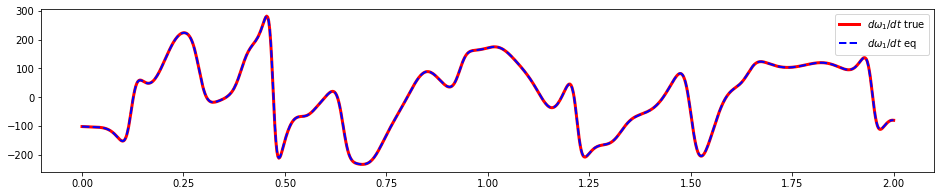

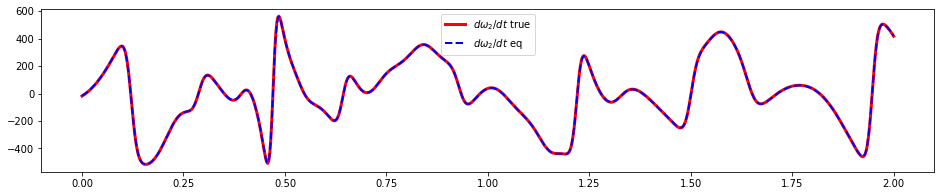

In [28]:
x1 = sim_measurement[:, 0]
x2 = sim_measurement[:, 1]
w1 = sim_measurement[:, 2]
w2 = sim_measurement[:, 3]

true_value_w1 = '(m2*L1*w1**2*sin(2*x1-2*x2) + 2*m2*L2*w2**2*sin(x1-x2) + 2*g*m2*cos(x2)*sin(x1-x2) + 2*g*m1*sin(x1))' + \
                '/ (-2*L1*(m2*sin(x1-x2)**2 + m1))'
true_value_w2 = '(m2*L2*w2**2*sin(2*x1-2*x2) + 2*(m1+m2)*L1*w1**2*sin(x1-x2) + 2*g*(m1+m2)*cos(x1)*sin(x1-x2))' + \
                '/ (2*L2*(m2*sin(x1-x2)**2 + m1))'

m1 = 35
m2 = 10
L1 = 9.1
L2 = 7
g = 981

dw1_true = eval(true_value_w1)
dw2_true = eval(true_value_w2)

x1 = torch.matmul(N_c, P[:, 0]).cpu().detach().numpy()
x2 = torch.matmul(N_c, P[:, 1]).cpu().detach().numpy()
w1 = torch.matmul(N_c, P[:, 2]).cpu().detach().numpy()
w2 = torch.matmul(N_c, P[:, 3]).cpu().detach().numpy()
dw1 = torch.matmul(N_dt, P[:, 2]).cpu().detach().numpy()
dw2 = torch.matmul(N_dt, P[:, 3]).cpu().detach().numpy()

plt.figure(figsize=(16,3))
plt.plot(t_m, dw1_true, 'k-', c='r', lw=3, label='$d\omega_1/dt$ true')
plt.plot(t_c[:-1], eval(function_dw1)[:-1], '--', c='b', lw=2, label='$d\omega_1/dt$ eq')

plt.legend()
plt.show()

plt.figure(figsize=(16,3))
plt.plot(t_m, dw2_true, 'k-', c='r', lw=3, label='$d\omega_2/dt$ true')
plt.plot(t_c[:-1], eval(function_dw2)[:-1], '--', c='b', lw=2, label='$d\omega_2/dt$ eq')
plt.legend()
plt.show()